In [1]:
reset -fs

In [2]:
import numpy as np
import pandas as pd
import os
import glob
import pickle
import gzip
import dl_functions
from IPython.display import display
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from skimage import io, color, exposure, transform
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### Loading data from a compressed pickle file that has 20,000 images pre-processed with a size of 50 by 50.

In [3]:
with gzip.open('pre_processed_images/image_data_20000_50.txt.gz', 'rb') as f:
  X, y = pickle.load(f)

#### Creating a train, test split.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### The labels need to be converted to categorical. Note that we have 2 categories: good (1) and bad (0) images.

In [5]:
y_train_sparse = np_utils.to_categorical(y_train, 2)

In [6]:
y_test_sparse = np_utils.to_categorical(y_test, 2)

#### Creating an instance of a CNN model.

##### The image size is 50.

In [7]:
IMG_SIZE = 50

In [8]:
model_1 = dl_functions.cnn_model_v_2(IMG_SIZE)

In [9]:
model_1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [10]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 19, 19, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 256)         295168    
__________

In [11]:
model_1.fit(X_train, y_train_sparse, batch_size=128, epochs=20, verbose=1, validation_split=0.3)

Train on 9800 samples, validate on 4200 samples
Epoch 1/20
9800/9800 [==============================] - 972s - loss: 7.8786 - acc: 0.5029 - val_loss: 8.1831 - val_acc: 0.4895
Epoch 2/20
9800/9800 [==============================] - 979s - loss: 7.9710 - acc: 0.5028 - val_loss: 8.1831 - val_acc: 0.4895
Epoch 3/20
9800/9800 [==============================] - 1011s - loss: 7.9710 - acc: 0.5028 - val_loss: 8.1831 - val_acc: 0.4895
Epoch 4/20
9800/9800 [==============================] - 961s - loss: 7.9710 - acc: 0.5028 - val_loss: 8.1831 - val_acc: 0.4895
Epoch 5/20
9800/9800 [==============================] - 951s - loss: 7.9710 - acc: 0.5028 - val_loss: 8.1831 - val_acc: 0.4895
Epoch 6/20
9800/9800 [==============================] - 954s - loss: 7.9710 - acc: 0.5028 - val_loss: 8.1831 - val_acc: 0.4895
Epoch 7/20
9800/9800 [==============================] - 1092s - loss: 7.9710 - acc: 0.5028 - val_loss: 8.1831 - val_acc: 0.4895
Epoch 8/20
9800/9800 [==============================] - 1003s

In [12]:
score = model_1.evaluate(X_test, y_test_sparse, verbose=1)

6000/6000 [==============================] - 147s   


In [13]:
print('Test loss: {:0,.4f}'.format(score[0]))
print('Test accuracy: {:.2%}'.format(score[1]))

Test loss: 7.9697
Test accuracy: 50.28%


#### Creating a list of predictions.

In [14]:
predicted_images = []
for i in model_1.predict(X_test):
  predicted_images.append(np.where(np.max(i) == i)[0])

#### Displaying a confusion matrix.

dl_functions.py:254: RuntimeWarning: invalid value encountered in divide
  'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),


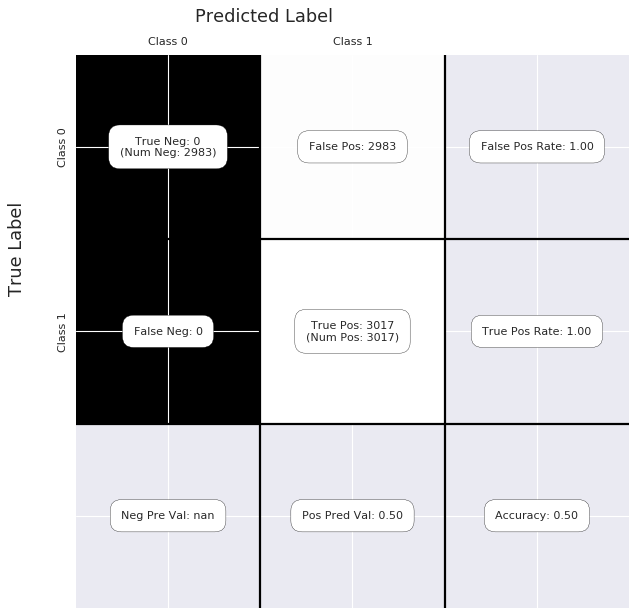

In [15]:
dl_functions.show_confusion_matrix(confusion_matrix(y_test, predicted_images), ['Class 0', 'Class 1'])

In [16]:
pd.DataFrame(confusion_matrix(y_test, predicted_images),columns = ['nok_image','ok_image'])

,nok_image,ok_image
0,0,2983
1,0,3017


In [17]:
predictions_probability = model_1.predict_proba(X_test)

6000/6000 [==============================] - 147s   


#### Plotting a ROC curve.

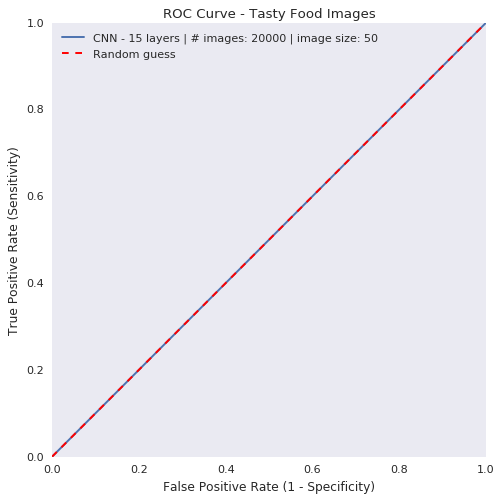

In [18]:
plt.figure(figsize=(7, 7))
dl_functions.plot_roc(y_test, predictions_probability[:,1], "CNN - " + str(len(model_1.layers)) + " layers | # images: " + str(len(X)) + " | image size: " + str(IMG_SIZE), "Tasty Food Images")

### Prediction using an image of Donald Trump.
<img src='images/trump_1.jpg' />

In [19]:
trump = dl_functions.normalize_images_array('images', IMG_SIZE)

In [20]:
trump_prediction = model_1.predict_classes(trump)

1/1 [==============================] - 0s


In [21]:
trump_prediction[0]

1

In [22]:
trump.shape

(1, 50, 50, 3)

In [23]:
trump = trump.reshape(trump.shape[1], trump.shape[2], trump.shape[3])

#### The model predicts the image as OK.

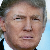

In [24]:
img = array_to_img(trump)
display(img)